In [1]:
import os
import importlib.util

import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import load_data, feature_names
from data.hlf_preprocessing import load



In [2]:
bsm_label_dict = {}
bsm_label_dict['Ato4l']=r'$A\rightarrow 4l$'
bsm_label_dict['leptoquark']='LQ'
bsm_label_dict['hToTauTau']=r'$h^{0}\rightarrow \tau\tau$'
bsm_label_dict['hChToTauNu']=r'$h^{\pm}\rightarrow \tau\nu$'

bsm_color_dict = {}
bsm_color_dict['Ato4l']='tab:green'
bsm_color_dict['leptoquark']='tab:purple'
bsm_color_dict['hToTauTau']='tab:orange'
bsm_color_dict['hChToTauNu']='tab:red'

bsm_list = ['Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']

In [3]:
data_path = '/home/oliverkn/pro/data/hlf_set_new'
max_samples=int(1e20)

data = {}
data['sm_mix'] = load_data(data_path, name='sm_mix', set='valid')
data['sm_mix_train'] = load_data(data_path, name='sm_mix', set='train')

for bsm in bsm_list:
    x = load_data(data_path, name=bsm, set='valid')
    if x.shape[0] > max_samples:
        x = x[:max_samples]
    data[bsm] = x

# loading vae reference
vae_roc = {}
vae_roc['Ato4l'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_Ato4l.pkl', 'rb'),
                               encoding='latin1')
vae_roc['leptoquark'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_leptoquark.pkl', 'rb'),
                                    encoding='latin1')
vae_roc['hToTauTau'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_hToTauTau.pkl', 'rb'),
                                   encoding='latin1')
vae_roc['hChToTauNu'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_hChToTauNu.pkl', 'rb'),
                                    encoding='latin1')
vae_roc['Wprime'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_Wprime.pkl', 'rb'),
                                encoding='latin1')
vae_roc['Zprime'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_Zprime.pkl', 'rb'),
                                encoding='latin1')

In [4]:
# result_path = '/home/oliverkn/pro/models/hlf/2_l16_ato4l_2e4/'
result_path = '/home/oliverkn/euler/results/hlf_set/alad/2_l16_7/'
weights_file = result_path + 'model-17500000'

# loading config
config_file = result_path + 'config.py'
spec = importlib.util.spec_from_file_location('config', config_file)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config, tf.Session())
ad.load(weights_file)

W1112 09:35:31.051271 140237608064832 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1112 09:35:31.165437 140237608064832 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1112 09:35:31.168589 140237608064832 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1112 09:35:31.169533 140237608064832 deprecation.py:323] From /home/oliverkn/euler/results/hlf_set/alad/2_l16_7/config.py:87: d

In [5]:
score_names = ['Features', r'$L_1$', r'$L_2$', 'Logits']
scores = {}

for key, x in data.items():
    print('processing ' + key)
    x = preprocessor.transform(x)
    scores[key] = ad.compute_all_scores(x)
    
print('finished')

processing sm_mix
processing sm_mix_train
processing Ato4l
processing leptoquark
processing hToTauTau
processing hChToTauNu
finished


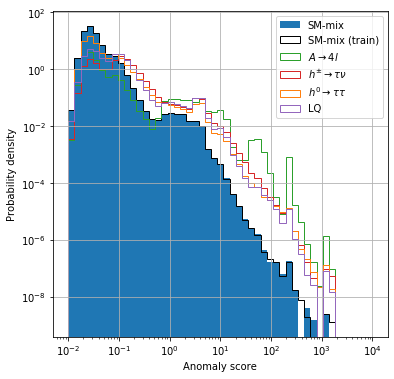

In [6]:
score_type = 1 # l1

n_bins = 50
bins = 10 ** np.linspace(-2, 4, n_bins)

fig, ax = plt.subplots(1, figsize=(6, 6))

ax.hist(scores['sm_mix'][score_type], bins, label='SM-mix', density=True, histtype='stepfilled')
ax.hist(scores['sm_mix_train'][score_type], bins, label='SM-mix (train)', color='black', density=True, histtype='step')
for key in ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']:
    ax.hist(scores[key][score_type], bins, label=bsm_label_dict[key], color=bsm_color_dict[key], density=True, histtype = 'step')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Anomaly score')
ax.set_ylabel('Probability density')
ax.grid()
ax.legend()

plt.savefig('figures/score_dist.pdf')
plt.show()

Ato4l
leptoquark
hToTauTau
hChToTauNu
saving
finished


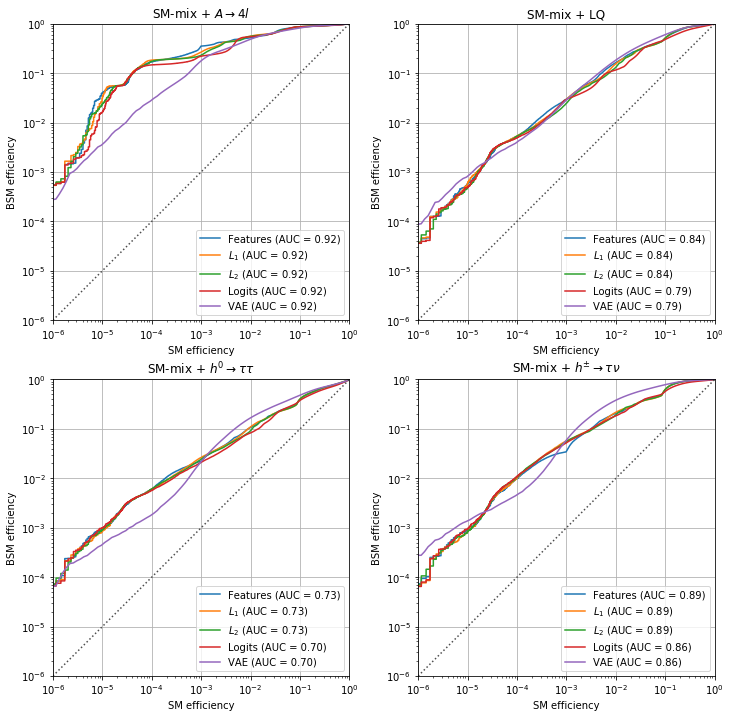

In [7]:
target_fpr = 1e-5

fig, ax_arr = plt.subplots(2, 2, figsize=(12, 12))
for i, key in enumerate(bsm_list):
    print(key)
    
    ax = ax_arr[i // 2, i % 2]
    ax.set(xlim=(1e-6, 1), ylim=(1e-6, 1))
    ax.set_aspect('equal')
    
    sm_scores = scores['sm_mix']
    bsm_scores = scores[key]
    labels = np.concatenate([np.zeros_like(sm_scores[0]), np.ones_like(bsm_scores[0])])
    
    for j, score_name in enumerate(score_names):
        y = np.concatenate([sm_scores[j], bsm_scores[j]])
        fpr, tpr, _ = roc_curve(labels, y, pos_label=1)
        auroc = roc_auc_score(labels, y)
        ax.loglog(fpr, tpr, label=score_name + ' (AUC = %.2f)' % auroc)
    
    # plot vae reference
    fpr, tpr, auc = vae_roc[key]['eff_SM'], vae_roc[key]['eff_BSM'], vae_roc[key]['roc_auc']
    ax.loglog(fpr, tpr, label='VAE (AUC = %.2f)' % auroc)

    # plot target_fpr line
    # ax.axvline(target_fpr, ls='--', color='magenta')
    
    #plot diagonal line
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls=":", c=".3")
    
    ax.set_title('SM-mix + ' + bsm_label_dict[key])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.grid()
    ax.legend(loc='lower right')

print('saving')
plt.savefig('figures/roc.pdf')
plt.show()
print('finished')

Ato4l
leptoquark
hToTauTau
hChToTauNu


/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


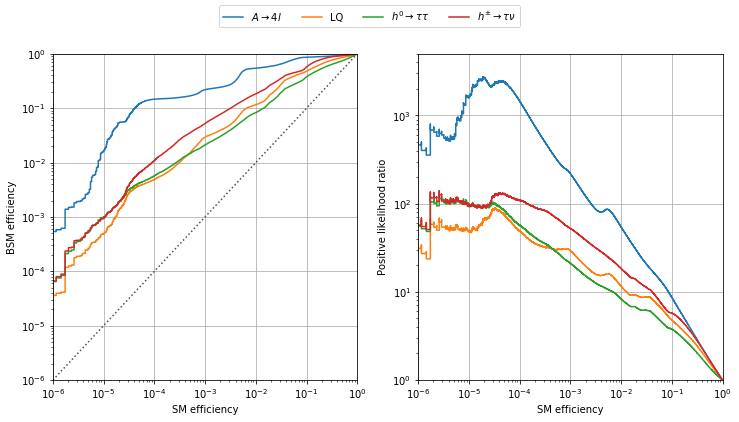

In [8]:
score_type = 3 # l1
fpr_lim = 1e-6

fig, ax_arr = plt.subplots(1, 2, figsize=(12, 6))

ax_arr[0].set(xlim=(fpr_lim, 1), ylim=(fpr_lim, 1))
ax_arr[0].set_xlabel('SM efficiency')
ax_arr[0].set_ylabel('BSM efficiency')
ax_arr[0].set_xscale('log')
ax_arr[0].set_yscale('log')
ax_arr[0].grid()

ax_arr[1].set(xlim=(fpr_lim, 1), ylim=(1, 5e3))
ax_arr[1].set_xlabel('SM efficiency')
ax_arr[1].set_ylabel('Positive likelihood ratio')
ax_arr[1].set_xscale('log')
ax_arr[1].set_yscale('log')
ax_arr[1].grid()

# for key in ['Ato4l']:
for key in bsm_list:
    print(key)
    
    sm_scores = scores['sm_mix'][score_type]
    bsm_scores = scores[key][score_type]
    y = np.concatenate([sm_scores, bsm_scores])
    labels = np.concatenate([np.zeros_like(sm_scores), np.ones_like(bsm_scores)])
    fpr, tpr, _ = roc_curve(labels, y, pos_label=1)
    ax_arr[0].step(fpr, tpr, label=bsm_label_dict[key])

    #plot LR+
    lrp = tpr/fpr
    ax_arr[1].step(fpr, lrp, label=bsm_label_dict[key])

#plot diagonal line
ax_arr[0].plot(ax.get_xlim(), ax.get_ylim(), ls=":", c=".3")

handles, labels = ax_arr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)

plt.savefig('figures/roc_lrp.pdf')
plt.show()